In [2]:
from __future__ import division
import numpy as np
import pandas as pd
import random
import csv
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

,swo
0,-10.2
1,-8.5
2,-5.7
3,-6.8


In [8]:
import sys
hydropath = "C:/Users/Hutto/PycharmProjects/hydromix"
sys.path.append(hydropath)
import hydromix
from hydromix.mixingfunctions import *

* Created on: 5th October 2018 (Harsh Beria)
* Last updated on: 22th November 2018 (Put the mixing part in another script GW_mixing_HydroMix.py)
* Last updated on: 21st December 2018 (Plots figure for snowfall vs snowmelt isotopic ratios)
* Creates synthetic time series of rain and snow isotopic ratio, & simulates isotopic ratio in groundwater
* Makes boxplots of isotopic ratio of snowfall vs snowmelt
* OutputFiles processed: OutputFiles/GW_conceptual/
* Figures made: OutputFiles/GW_conceptual/SF_SM_boxplot.jpeg

In [9]:
# Percentage of rain and snow recharging groundwater
RAIN_EFF = 1. 
SNOW_EFF = 1.
K_Q = 0.1  # For Q = KS
DEGDAYFACT = 2.5  # Degree day factor in mm/C/day
TMELT = 0.  # Temperature at which snowpack starts melting
const_storage = 1000. 
init_snow = 0.  # Constant storage in groundwater which is not fed to streamflow and initial snow height in catchment
varLSnowTemp = -1. 
varHSnowTemp = 1.  # Threshold temperature for bounding thresholding method for snowfall estimation

# Parameters for generation of air temperature, precipitation and precipitation isotopic ratio
YEARS = 100  # Number of years for which simulation is carried out
AirTempMean = 4. 
AirTempAmpl = 8.
PrecipEventNumb = 30
PrecipMean = 1000.
PrecipIsoMean = -80.
PrecipIsoAmpl = 40.

# To save records into a csv file
FINAL_LIS = [["Day number", "Rainfall (mm)", "Snowfall (mm)", 
              "Storage (mm)", "Snowmelt (mm)", "Snowheight (mm)",
              "Q from GW (mm)",
              "Rain recharge (mm)", "Snow recharge (mm)", 
              "Precip isotopic ratio", "Snowpack isotopic ratio",
              "Storage isotopic ratio"]]
snowMeltIso = []  # For storing snowmelt isotopic ratios
outputpath = "C:/Users/Hutto/PycharmProjects/hydromix/OutputFiles/GW_conceptual/"

# Mixing model parameters
NUMBER_ITERATIONS = 1000
LAMBDA_RANGE = [0., 1.]  # LAMBDA values imply the fraction of snow in groundwater
# Number of best simulations using which lambda is computed
BEST_SIM_PER = 5.  # In percentage

LAST_YEARS = 1  # Number of years at the end of the timeseries from which isotopic data is sampled


In [10]:
np.random.seed(15544)  # Setting up a common seed number
random.seed(55452)  # Setting up random seed for the random function

# %% Time series of air temperature, precipitation and isotopic ratio of precipitation
airTemp = air_temp_gen(mean_temp=AirTempMean, ampl_temp=AirTempAmpl, years=YEARS)
prcp = poisson_prcp(numb_event=PrecipEventNumb, mean_prcp=PrecipMean, years=YEARS)
prcpIso = prcp_iso(mean_iso=PrecipIsoMean, ampl_iso=PrecipIsoAmpl, years=YEARS)
dayNumb = np.linspace(1, 365 * YEARS, 365 * YEARS)  # Day numbering

# %% Running the hydrologic model
storage = [const_storage]  # Catchment storage
snow_height = [init_snow]  # Snow height
snow_melt = [0.]  # Snow melt
storage_C = [0.]  # Isotopic ratio in catchment storage (groundwater)
snow_C = [0.]  # Isotopic ratio in snowpack
rain_lis = [0.]
snow_lis = [0.]  # Daily rainfall and snowfall amount
recharge_rain_lis = [0.]
recharge_snow_lis = [0.]  # Daily groundwater recharge values from rainfall and snowmelt
Q_flow = [0.]  # Daily flow into the stream from groundwater

In [11]:
for index in range(len(dayNumb)):

    # Estimating amount of rain and snow
    if airTemp[index] <= varLSnowTemp:
        rain_frac = 0.
    elif airTemp[index] >= varHSnowTemp:
        rain_frac = 1.
    else:
        rain_frac = (airTemp[index] - varLSnowTemp) * 1. / (varHSnowTemp - varLSnowTemp)
    rain_mag = rain_frac * prcp[index] * 1.
    snow_mag = (1 - rain_frac) * prcp[index] * 1.
    rain_lis.append(rain_mag)
    snow_lis.append(snow_mag)

    # Computing snow height and snowmelt volume
    if airTemp[index] >= TMELT:
        melt = DEGDAYFACT * (airTemp[index] - TMELT)
        if melt > snow_height[-1]:  # Applying limit of available storage
            melt = snow_height[-1] + snow_lis[-1]
    else:
        melt = 0.
    snow_height.append(snow_height[-1] + snow_lis[-1] - melt)
    snow_melt.append(melt)

    # Isotopic ratio of snowpack
    if snow_height[-1] == 0.:  # No more snowpack left
        newC = 0.
    else:
        newC = (snow_height[-2] * snow_C[-1] + snow_lis[-1] * prcpIso[index] - melt * snow_C[-1]) * 1. / (
                snow_height[-2] + snow_lis[-1] - melt)
        snowMeltIso.append(newC)
    snow_C.append(newC)

    # Computing groundwater recharge from rain and snow
    recharge_rain, recharge_snow = rain_lis[-1] * RAIN_EFF * 1., snow_melt[-1] * SNOW_EFF * 1.
    recharge_rain_lis.append(recharge_rain)
    recharge_snow_lis.append(recharge_snow)

    recharge = recharge_rain + recharge_snow
    storage.append(storage[-1] + recharge)
    Q = K_Q * (storage[-1] - const_storage)  # Flow into streamflow from groundwater
    storage[-1] -= Q  # Updating groundwater volume
    Q_flow.append(Q)

    # Isotopic ratio of groundwater storage
    if round(storage[-1], 2) == 0.:
        newC = 0.
    else:
        newC = (storage[-2] * storage_C[-1] + rain_lis[-1] * RAIN_EFF * prcpIso[index] + snow_melt[-1] * SNOW_EFF *
                snow_C[-2] - Q * storage_C[-1]) * 1. / (
                       storage[-2] + rain_lis[-1] * RAIN_EFF + snow_melt[-1] * SNOW_EFF - Q)
    storage_C.append(newC)

    FINAL_LIS.append(
        [dayNumb[index], rain_lis[-1], snow_lis[-1], storage[-1], snow_melt[-1], snow_height[-1], Q_flow[-1],
         recharge_rain_lis[-1], recharge_snow_lis[-1], prcpIso[index], snow_C[-1], storage_C[-1]])

C:/Users/Hutto/PycharmProjects/hydromix/OutputFiles/GW_conceptual/RAIN_1.0_SNOW_1.0.csv
C:/Users/Hutto/PycharmProjects/hydromix/OutputFiles/GW_conceptual/Figures/SF_SM_boxplot.jpeg


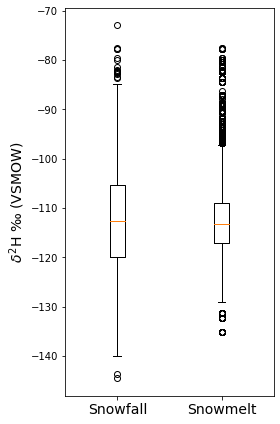

In [12]:
# %% Saving the simulated data into a csv file

path = f"{outputpath}RAIN_{RAIN_EFF:0.1f}_SNOW_{SNOW_EFF:0.1f}.csv"
csv_writer(FINAL_LIS, path)
print(path)

# %% Plotting boxplots of snowfall and snowmelt

snowFallIso = prcpIso[(prcp > 0.) & (airTemp < (0.5 * (varLSnowTemp + varHSnowTemp)))]  # Snowfall isotopic ratios

matplotlib.rc('xtick', labelsize=14)
plt.figure(figsize=(4, 6))
plt.boxplot([snowFallIso, snowMeltIso], labels=["Snowfall", "Snowmelt"])
plt.ylabel(r'$\delta^{2}$' + 'H ' + u'\u2030' + ' (VSMOW)', fontsize=14)
plt.tight_layout()
path = outputpath + "Figures/SF_SM_boxplot.jpeg"
plt.savefig(path, dpi=300)

print(path)

In [13]:
len(snowFallIso)

970

In [14]:
len(snowMeltIso)

15296